In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,  accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from scipy.sparse import hstack
from sklearn.feature_selection import VarianceThreshold, RFE
import sklearn.metrics
import re
from xgboost import XGBClassifier
import seaborn as sns
import os
import string
import textstat
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('data/02_movie_metadata.csv')


In [6]:
df_topic_coh = pd.read_csv('data/topic_coherence_scores.csv')

In [7]:
df_sent_sum = pd.read_csv('data/sentiment_summ.csv')
df_sent_sum.rename(columns={'Id':'imdbid'},inplace=True)
df_sent_sum.rename(str.lower, axis='columns', inplace=True)
df_sent_sum['rel_sent_turns'] = df_sent_sum['sentiment_num_turns'] / df_sent_sum['scenes_count']
df_sent_sum

,name,imdbid,sentiment_score_average,sentiment_score_mean_squared_deviation,sentiment_num_turns,scenes_count,rel_sent_turns
0,The Changeling,80516,0.043130,0.596833,20,54,0.370370
1,Batman v Superman Dawn of Justice,2975590,0.001235,0.529702,44,135,0.325926
2,Panther,114084,-0.224685,0.466195,48,151,0.317881
3,Slash,4729990,-0.188082,0.544121,21,56,0.375000
4,Blue Velvet,90756,0.126827,0.406182,57,231,0.246753
...,...,...,...,...,...,...,...
2851,Final Destination 2,309593,-0.377748,0.460963,30,81,0.370370
2852,Hellboy II The Golden Army,411477,-0.103719,0.460767,51,131,0.389313
2853,Munich,408306,-0.162806,0.369601,80,244,0.327869
2854,My Cousin Vinny,104952,-0.179231,0.458608,32,103,0.310680


In [95]:
# df = pd.merge(df, df_topic_coh, how='left', on='imdbid')

In [8]:
df = pd.merge(df, df_sent_sum, how='left', on='imdbid')
df

,imdbid,title,year,age_rating,genre,description,director,runtime_minutes,production_budget,domestic_gross,...,average_betweenness_centrality,average_interaction_diversity,normalized_interaction_coefficient,scene_length_cv,name,sentiment_score_average,sentiment_score_mean_squared_deviation,sentiment_num_turns,scenes_count,rel_sent_turns
0,120770,A Night at the Roxbury,1998,PG-13,"Comedy, Music, Romance",Two dim-witted brothers dream of owning their ...,John Fortenberry,82.0,17000000.0,30331165.0,...,0.055944,4.615385,10.435897,3.462057,A Night at the Roxbury,0.237414,0.447804,46.0,104.0,0.442308
1,132512,At First Sight,1999,PG-13,"Drama, Romance",A blind man has an operation to regain his sig...,Irwin Winkler,128.0,40000000.0,22365133.0,...,0.043124,6.307692,10.115385,3.294203,At First Sight,0.404350,0.339994,38.0,135.0,0.281481
2,118661,The Avengers,1998,PG-13,"Action, Adventure, Sci-Fi",Two British Agents team up to stop Sir August ...,Jeremiah S. Chechik,143.0,225000000.0,623357910.0,...,0.067460,4.222222,13.861111,2.386720,The Avengers,0.082393,0.453896,41.0,109.0,0.376147
3,118715,The Big Lebowski,1998,R,"Comedy, Crime","Ultimate L.A. slacker Jeff ""The Dude"" Lebowski...","Joel Coen, \nEthan Coen",117.0,15000000.0,17498804.0,...,0.045363,3.619048,4.238095,2.481261,The Big Lebowski,-0.004556,0.673269,20.0,57.0,0.350877
4,112573,Braveheart,1995,R,"Biography, Drama, History",Scottish warrior William Wallace leads his cou...,Mel Gibson,178.0,72000000.0,75545647.0,...,0.038847,6.857143,1.928571,3.704146,Braveheart,-0.203509,0.526184,44.0,108.0,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,2209764,Transcendence,2014,PG-13,"Action, Drama, Sci-Fi",A scientist's drive for artificial intelligenc...,Wally Pfister,119.0,100000000.0,23022309.0,...,0.050117,5.384615,5.987179,2.313989,Transcendence,-0.342128,0.400746,39.0,170.0,0.229412
1207,418279,Transformers,2007,PG-13,"Action, Adventure, Sci-Fi",An ancient struggle between two Cybertronian r...,Michael Bay,144.0,151000000.0,319246193.0,...,0.037582,7.777778,2.313725,1.044824,Transformers,-0.118372,0.431758,52.0,148.0,0.351351
1208,6499752,Upgrade,2018,R,"Action, Sci-Fi, Thriller","Set in the near-future, technology controls ne...",Leigh Whannell,100.0,3000000.0,11977130.0,...,0.057576,4.666667,4.484848,2.442203,Upgrade,-0.134102,0.448015,43.0,123.0,0.349593
1209,1976009,Victor Frankenstein,2015,PG-13,"Drama, Horror, Sci-Fi","Told from Igor's perspective, we see the troub...",Paul McGuigan,110.0,40000000.0,5775076.0,...,0.044643,6.500000,5.833333,2.908938,Victor Frankenstein,0.017564,0.594633,22.0,78.0,0.282051


In [9]:
df['imdbid'] = df['imdbid'].apply(lambda x: f'{x:07d}')

In [10]:
age_dummies = pd.get_dummies(df['age_rating_number'], prefix = 'age', drop_first=True, dtype=int)
df = pd.concat([df, age_dummies], axis=1)
df


,imdbid,title,year,age_rating,genre,description,director,runtime_minutes,production_budget,domestic_gross,...,name,sentiment_score_average,sentiment_score_mean_squared_deviation,sentiment_num_turns,scenes_count,rel_sent_turns,age_6,age_13,age_17,age_18
0,0120770,A Night at the Roxbury,1998,PG-13,"Comedy, Music, Romance",Two dim-witted brothers dream of owning their ...,John Fortenberry,82.0,17000000.0,30331165.0,...,A Night at the Roxbury,0.237414,0.447804,46.0,104.0,0.442308,0,1,0,0
1,0132512,At First Sight,1999,PG-13,"Drama, Romance",A blind man has an operation to regain his sig...,Irwin Winkler,128.0,40000000.0,22365133.0,...,At First Sight,0.404350,0.339994,38.0,135.0,0.281481,0,1,0,0
2,0118661,The Avengers,1998,PG-13,"Action, Adventure, Sci-Fi",Two British Agents team up to stop Sir August ...,Jeremiah S. Chechik,143.0,225000000.0,623357910.0,...,The Avengers,0.082393,0.453896,41.0,109.0,0.376147,0,1,0,0
3,0118715,The Big Lebowski,1998,R,"Comedy, Crime","Ultimate L.A. slacker Jeff ""The Dude"" Lebowski...","Joel Coen, \nEthan Coen",117.0,15000000.0,17498804.0,...,The Big Lebowski,-0.004556,0.673269,20.0,57.0,0.350877,0,0,1,0
4,0112573,Braveheart,1995,R,"Biography, Drama, History",Scottish warrior William Wallace leads his cou...,Mel Gibson,178.0,72000000.0,75545647.0,...,Braveheart,-0.203509,0.526184,44.0,108.0,0.407407,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,2209764,Transcendence,2014,PG-13,"Action, Drama, Sci-Fi",A scientist's drive for artificial intelligenc...,Wally Pfister,119.0,100000000.0,23022309.0,...,Transcendence,-0.342128,0.400746,39.0,170.0,0.229412,0,1,0,0
1207,0418279,Transformers,2007,PG-13,"Action, Adventure, Sci-Fi",An ancient struggle between two Cybertronian r...,Michael Bay,144.0,151000000.0,319246193.0,...,Transformers,-0.118372,0.431758,52.0,148.0,0.351351,0,1,0,0
1208,6499752,Upgrade,2018,R,"Action, Sci-Fi, Thriller","Set in the near-future, technology controls ne...",Leigh Whannell,100.0,3000000.0,11977130.0,...,Upgrade,-0.134102,0.448015,43.0,123.0,0.349593,0,0,1,0
1209,1976009,Victor Frankenstein,2015,PG-13,"Drama, Horror, Sci-Fi","Told from Igor's perspective, we see the troub...",Paul McGuigan,110.0,40000000.0,5775076.0,...,Victor Frankenstein,0.017564,0.594633,22.0,78.0,0.282051,0,1,0,0


In [11]:

df = df.drop([ 'title', 'year','age_rating', 'genre', 'description',
       'director', 'domestic_gross','age_rating_number',
       'worldwide_gross', 'ROI', 'name', 'sentiment_num_turns',
       'scenes_count'], axis=1)


In [12]:
df.columns

Index(['imdbid', 'runtime_minutes', 'production_budget', 'financial_success',
       'genre_action', 'genre_adventure', 'genre_animation', 'genre_biography',
       'genre_comedy', 'genre_crime', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_film-noir', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_romance',
       'genre_sci-fi', 'genre_sport', 'genre_thriller', 'genre_war',
       'genre_western', 'average_degree_centrality',
       'average_closeness_centrality', 'average_betweenness_centrality',
       'average_interaction_diversity', 'normalized_interaction_coefficient',
       'scene_length_cv', 'sentiment_score_average',
       'sentiment_score_mean_squared_deviation', 'rel_sent_turns', 'age_6',
       'age_13', 'age_17', 'age_18'],
      dtype='object')

# Train Test Split and reading texts

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [14]:
df_train.groupby('financial_success').count()

,imdbid,runtime_minutes,production_budget,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,...,average_interaction_diversity,normalized_interaction_coefficient,scene_length_cv,sentiment_score_average,sentiment_score_mean_squared_deviation,rel_sent_turns,age_6,age_13,age_17,age_18
financial_success,,,,,,,,,,,,,,,,,,,,,
0,315,315,315,315,315,315,315,315,315,315,...,315,315,315,315,315,315,315,315,315,315
1,653,653,653,653,653,653,653,653,653,653,...,653,652,653,653,653,653,653,653,653,653


In [15]:
df_test.groupby('financial_success').count()

,imdbid,runtime_minutes,production_budget,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,...,average_interaction_diversity,normalized_interaction_coefficient,scene_length_cv,sentiment_score_average,sentiment_score_mean_squared_deviation,rel_sent_turns,age_6,age_13,age_17,age_18
financial_success,,,,,,,,,,,,,,,,,,,,,
0,105,105,105,105,105,105,105,105,105,105,...,105,104,105,104,104,104,105,105,105,105
1,138,138,138,138,138,138,138,138,138,138,...,138,137,138,138,138,138,138,138,138,138


In [16]:
scaler = StandardScaler()
columns_to_scale = ['runtime_minutes', 'production_budget','average_degree_centrality',
'average_closeness_centrality', 'average_betweenness_centrality',
'average_interaction_diversity', 'normalized_interaction_coefficient',
'scene_length_cv']
df_train[columns_to_scale]= scaler.fit_transform(df_train[columns_to_scale])
df_test[columns_to_scale]= scaler.transform(df_test[columns_to_scale])


In [17]:
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Raw text

In [18]:
from charset_normalizer import from_path

# Folder containing the text files
folder_path = 'data/screenplay_data/data/raw_texts/raw_texts/'

# List to store the contents of the text files
raw_train_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_train['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            result = from_path(file_path).best()
            with open(file_path, 'r', encoding=result.encoding) as file:
                content = file.read()
                # Add the content to the list
                raw_train_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_train_corr = df_train[df_train['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_train = df_train_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [19]:
folder_path = 'data/screenplay_data/data/raw_texts/raw_texts/'

# List to store the contents of the text files
raw_test_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_test['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            result = from_path(file_path).best()
            with open(file_path, 'r', encoding=result.encoding) as file:
                content = file.read()
                # Add the content to the list
                raw_test_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_test_corr = df_test[df_test['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_test = df_test_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243


## Dropping imdbid and financial success

In [20]:
df_train_corr = df_train_corr.drop(['imdbid', 'financial_success'], axis=1)
df_test_corr = df_test_corr.drop(['imdbid', 'financial_success'], axis=1)
df_test_corr

,runtime_minutes,production_budget,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,genre_family,...,average_interaction_diversity,normalized_interaction_coefficient,scene_length_cv,sentiment_score_average,sentiment_score_mean_squared_deviation,rel_sent_turns,age_6,age_13,age_17,age_18
0,0.730442,0.025323,0,0,0,1,0,0,1,0,...,-1.250808,-0.306680,-0.297981,0.012505,0.459377,0.287879,0,0,1,0
1,1.440586,-0.604593,0,0,0,0,0,0,1,0,...,-1.250808,0.461549,0.019876,-0.218306,0.469107,0.289855,0,0,1,0
2,-0.784534,-0.584273,1,0,0,0,0,0,0,0,...,-0.821588,-0.304769,-0.428788,-0.186946,0.409333,0.379562,0,0,1,0
3,0.114983,-0.736672,0,0,0,0,0,0,0,0,...,0.519725,0.461900,-0.615672,0.044119,0.522892,0.228916,0,1,0,0
4,1.440586,0.228521,1,0,0,0,0,1,1,0,...,-0.734402,-0.095821,0.025157,0.107170,0.444215,0.266667,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.067640,-0.421714,1,0,0,0,0,1,1,0,...,0.027910,0.556286,0.207430,0.164354,0.516732,0.347107,0,0,1,0
239,0.683099,1.650912,0,1,0,0,1,0,0,1,...,2.402673,-0.335671,1.688220,0.647708,0.252138,0.135135,1,0,0,0
240,-0.121732,-0.381075,1,1,0,0,0,0,0,0,...,1.188593,-0.321611,-1.597631,-0.305145,0.344561,0.296296,0,0,1,0
241,-0.027046,0.878757,1,1,1,0,0,0,0,0,...,0.322999,-0.291837,-1.036723,0.249541,0.509137,0.296296,1,0,0,0


In [21]:
df_test_corr.columns

Index(['runtime_minutes', 'production_budget', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_drama', 'genre_family', 'genre_fantasy',
       'genre_film-noir', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_romance', 'genre_sci-fi',
       'genre_sport', 'genre_thriller', 'genre_war', 'genre_western',
       'average_degree_centrality', 'average_closeness_centrality',
       'average_betweenness_centrality', 'average_interaction_diversity',
       'normalized_interaction_coefficient', 'scene_length_cv',
       'sentiment_score_average', 'sentiment_score_mean_squared_deviation',
       'rel_sent_turns', 'age_6', 'age_13', 'age_17', 'age_18'],
      dtype='object')

In [22]:

df_raw_train = pd.DataFrame(raw_train_texts, columns=['raw'])
df_raw_test = pd.DataFrame(raw_test_texts, columns=['raw'])


#remove formatting from raw text
df_raw_train['raw'] = df_raw_train['raw'].str.replace(r'\s+', ' ', regex=True).str.strip().str.lower()
df_raw_test['raw'] = df_raw_test['raw'].str.replace(r'\s+', ' ', regex=True).str.strip().str.lower()

### Adding a cleanup and lem step ourselves

In [23]:
# 3 min

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Function to lemmatize text
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply the preprocessing steps
df_raw_train['lem'] = df_raw_train['raw'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize_text)
df_raw_test['lem'] = df_raw_test['raw'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize_text)



# TFIDF

### TFIDF with our own cleaned scripts

In [24]:
#1 min 
vect2 = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_train_tfidf_lem = vect2.fit_transform(df_raw_train['lem'])
X_test_tfidf_lem = vect2.transform(df_raw_test['lem'])

In [25]:

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vect2, f)

Accuracy on train set: 1.0
Accuracy on test set: 0.56
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.13      0.21       105
           1       0.57      0.88      0.70       138

    accuracy                           0.56       243
   macro avg       0.52      0.51      0.45       243
weighted avg       0.53      0.56      0.48       243

--------------------------------------------------------------------------------


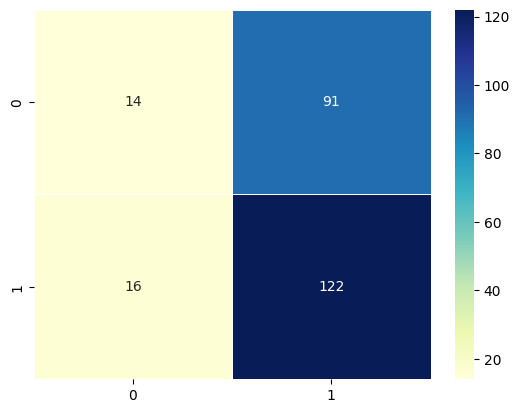

In [26]:
clf_tfidf = XGBClassifier()
clf_tfidf.fit(X_train_tfidf_lem, y_train)

y_pred_tfidf_train = clf_tfidf.predict(X_train_tfidf_lem)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf_lem)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_tfidf_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_tfidf), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_tfidf))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [27]:
with open('models/clf_tfidf.pkl', 'wb') as f:
    pickle.dump(clf_tfidf, f)

# Latent Semantic Analysis (LSA)

### LSA on own lemmatized script with TFIDF

In [28]:
lsa = TruncatedSVD(n_components=300, random_state=0)
X_train_lsa_lem = lsa.fit_transform(X_train_tfidf_lem)
X_test_lsa_lem = lsa.transform(X_test_tfidf_lem)

In [29]:
with open('models/lsa.pkl', 'wb') as f:
    pickle.dump(lsa, f)

Accuracy on train set: 1.0
Accuracy on test set: 0.57
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.11      0.19       105
           1       0.58      0.91      0.71       138

    accuracy                           0.57       243
   macro avg       0.54      0.51      0.45       243
weighted avg       0.54      0.57      0.48       243

--------------------------------------------------------------------------------


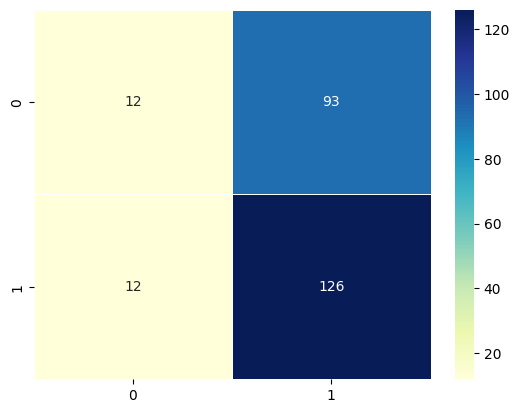

In [30]:
clf_lsa = XGBClassifier()
clf_lsa.fit(X_train_lsa_lem, y_train)

y_pred_lsa_train = clf_lsa.predict(X_train_lsa_lem)
y_pred_lsa = clf_lsa.predict(X_test_lsa_lem)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_lsa_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_lsa), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_lsa))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred_lsa)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [31]:
with open('models/clf_lsa.pkl', 'wb') as f:
    pickle.dump(clf_lsa, f)

# Textblob

In [33]:
#2min 
from textblob import TextBlob

def sentiment_features(text):
    blob = TextBlob(text)
    return pd.Series({'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity})

df_train_corr[['polarity', 'subjectivity']] = df_raw_train['raw'].apply(sentiment_features)
df_test_corr[['polarity', 'subjectivity']] = df_raw_test['raw'].apply(sentiment_features)

# LDA

In [34]:
#8 min

# Apply CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_counts = vectorizer.fit_transform(df_raw_train['raw'])
X_test_counts = vectorizer.transform(df_raw_test['raw'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
X_train_topics = lda.fit_transform(X_train_counts)
X_test_topics = lda.transform(X_test_counts)

# Add LDA topic distribution to the DataFrame
lda_columns = [f'topic_{i}' for i in range(X_train_topics.shape[1])]
df_train_lda = pd.DataFrame(X_train_topics, columns=lda_columns)
df_test_lda = pd.DataFrame(X_test_topics, columns=lda_columns)
# df = pd.concat([df, df_lda], axis=1)

In [35]:
with open('models/counts.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [36]:
with open('models/lda.pkl', 'wb') as f:
    pickle.dump(lda, f)

# Readability score

In [37]:
#1 min
def readability_features(text):
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    return {'flesch_reading_ease': flesch_reading_ease, 'flesch_kincaid_grade': flesch_kincaid_grade}

# flesch_train_reading_ease = df_raw_train[0].apply(textstat.flesch_reading_ease)
# flesch_train_kincaid_grade = df_raw_train[0].apply(textstat.flesch_kincaid_grade)
df_train_read = df_raw_train['raw'].apply(readability_features).apply(pd.Series)
df_test_read = df_raw_test['raw'].apply(readability_features).apply(pd.Series)

# Glove

In [39]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings('data/glove.6B/glove.6B.300d.txt')
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
def get_script_embedding(script, embeddings_index, embedding_dim=300):
    words = script.split()
    valid_embeddings = [embeddings_index[word] for word in words if word in embeddings_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

# df_train_corr['script_embedding'] = df_raw_train[0].apply(lambda x: get_script_embedding(x, embeddings_index))
# X_train_text = np.vstack(df_train_corr['script_embedding'].values)
X_train_text = np.vstack(df_raw_train['raw'].apply(lambda x: get_script_embedding(x, embeddings_index)).values)

# df_test_corr['script_embedding'] = df_raw_test[0].apply(lambda x: get_script_embedding(x, embeddings_index))
# X_test_text = np.vstack(df_test_corr['script_embedding'].values)X_test_text = np.vstack(df_raw_test['raw'].apply(lambda x: get_script_embedding(x, embeddings_index)).values)
X_test_text = np.vstack(df_raw_test['raw'].apply(lambda x: get_script_embedding(x, embeddings_index)).values)

Accuracy on train set: 1.0
Accuracy on test set: 0.55
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.13      0.20       105
           1       0.57      0.86      0.68       138

    accuracy                           0.55       243
   macro avg       0.50      0.50      0.44       243
weighted avg       0.51      0.55      0.48       243

--------------------------------------------------------------------------------


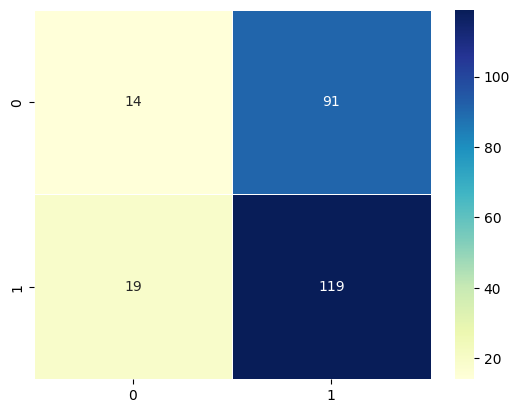

In [ ]:
clf_glove = XGBClassifier()
clf_glove.fit(X_train_text, y_train)

y_pred_glove_train = clf_glove.predict(X_train_text)
y_pred_glove = clf_glove.predict(X_test_text)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_glove_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_glove), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_glove))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred_glove)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [ ]:
with open('models/clf_glove.pkl', 'wb') as f:
    pickle.dump(clf_glove, f)

# combinatied XGBoost

In [ ]:
X_train_combined = pd.concat([df_train_corr, df_train_lda, df_train_read], axis=1)
X_test_combined = pd.concat([df_test_corr, df_test_lda, df_test_read], axis=1)

X_train_combined


,runtime_minutes,production_budget,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,genre_family,...,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,flesch_reading_ease,flesch_kincaid_grade
0,0.635756,3.682898,1,1,0,0,0,0,0,0,...,0.000007,0.173990,0.000007,0.714899,0.000007,0.000007,0.103654,0.007413,82.65,5.2
1,0.446384,0.431720,0,1,0,0,0,0,1,0,...,0.000008,0.000008,0.623117,0.000008,0.000008,0.373191,0.000303,0.000008,87.31,3.4
2,0.304355,0.126922,1,0,0,0,0,1,0,0,...,0.000008,0.106746,0.000008,0.767924,0.000008,0.000108,0.125174,0.000008,82.44,5.3
3,1.061842,-0.177876,0,0,0,0,0,1,1,0,...,0.000006,0.000006,0.995045,0.000006,0.000006,0.001035,0.000006,0.003877,87.21,3.5
4,1.251214,-0.177876,0,0,0,0,0,0,1,0,...,0.923471,0.000009,0.001032,0.000009,0.000009,0.041200,0.029595,0.000009,79.46,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,-0.689848,-0.939871,0,0,0,0,0,0,1,0,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.007519,0.992365,0.000015,85.08,4.3
964,-0.074389,0.594279,0,0,0,0,0,0,0,0,...,0.000011,0.000011,0.000011,0.704474,0.256126,0.013715,0.000011,0.025620,87.21,3.5
965,0.067640,1.447713,1,0,0,0,0,1,0,0,...,0.000382,0.008109,0.107376,0.034657,0.000007,0.000007,0.000007,0.000007,87.11,3.5
966,-1.352650,-0.685872,0,0,0,0,0,0,0,0,...,0.000011,0.006025,0.000011,0.013761,0.000011,0.971292,0.000011,0.008859,87.62,3.3


Accuracy on train set: 1.0
Accuracy on test set: 0.56
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.21      0.29       105
           1       0.58      0.83      0.68       138

    accuracy                           0.56       243
   macro avg       0.53      0.52      0.49       243
weighted avg       0.54      0.56      0.52       243

--------------------------------------------------------------------------------


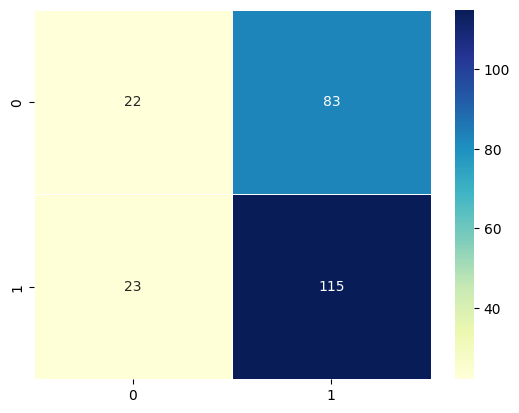

In [ ]:
clf_combined = XGBClassifier()
clf_combined.fit(X_train_combined, y_train)

y_pred_combined_train = clf_combined.predict(X_train_combined)
y_pred_combined = clf_combined.predict(X_test_combined)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_combined_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_combined), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_combined))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred_combined)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Fitting 5 folds for each of 3645 candidates, totalling 18225 fits
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.57      0.99      0.72       138

    accuracy                           0.56       243
   macro avg       0.28      0.50      0.36       243
weighted avg       0.32      0.56      0.41       243

ROC_score:  0.4963768115942029


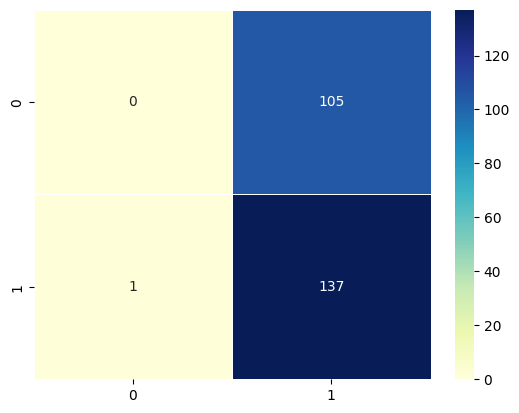

In [ ]:

# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
gs = GridSearchCV(XGBClassifier(), param_grid,  scoring='accuracy',
                  cv=5, verbose=3, n_jobs=-1)

# Fit randomized search object to data
gs.fit(X_train_combined, y_train)

gs_best = gs.best_estimator_
y_pred = gs_best.predict(X_test_combined)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [ ]:
X_test_combined.columns

Index(['runtime_minutes', 'production_budget', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_drama', 'genre_family', 'genre_fantasy',
       'genre_film-noir', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_romance', 'genre_sci-fi',
       'genre_sport', 'genre_thriller', 'genre_war', 'genre_western',
       'average_degree_centrality', 'average_closeness_centrality',
       'average_betweenness_centrality', 'average_interaction_diversity',
       'normalized_interaction_coefficient', 'scene_length_cv',
       'sentiment_score_average', 'sentiment_score_mean_squared_deviation',
       'rel_sent_turns', 'age_6', 'age_13', 'age_17', 'age_18', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'flesch_reading_ease',
       'flesch_kincaid_grade'],
      dtype='object')

In [ ]:
with open('models/clf_combined.pkl', 'wb') as f:
    pickle.dump(clf_combined, f)

### how does the stacking make sense? too many columns.. ensemble methods instead?

In [ ]:
y_pred_tfidf_train = clf_tfidf.predict_proba(X_train_tfidf_lem)
y_pred_tfidf = clf_tfidf.predict_proba(X_test_tfidf_lem)

y_pred_lsa_train = clf_lsa.predict_proba(X_train_lsa_lem)
y_pred_lsa = clf_lsa.predict_proba(X_test_lsa_lem)

y_pred_glove_train = clf_glove.predict_proba(X_train_text)
y_pred_glove = clf_glove.predict_proba(X_test_text)

y_pred_combined_train = clf_combined.predict_proba(X_train_combined)
y_pred_combined = clf_combined.predict_proba(X_test_combined)



In [ ]:
X_train_stack = np.column_stack((y_pred_tfidf_train, y_pred_lsa_train, y_pred_glove_train, y_pred_combined_train))
X_test_stack = np.column_stack((y_pred_tfidf, y_pred_lsa, y_pred_glove, y_pred_combined))
X_test_stack


array([[0.23769855, 0.76230145, 0.02567554, ..., 0.5220269 , 0.39905035,
        0.60094965],
       [0.03536177, 0.96463823, 0.49704444, ..., 0.85609704, 0.04286069,
        0.9571393 ],
       [0.1412316 , 0.8587684 , 0.02029908, ..., 0.919561  , 0.05945164,
        0.94054836],
       ...,
       [0.12219667, 0.8778033 , 0.11229575, ..., 0.9975969 , 0.26417905,
        0.73582095],
       [0.00830716, 0.99169284, 0.02149934, ..., 0.8179128 , 0.5218623 ,
        0.47813767],
       [0.09165549, 0.9083445 , 0.04134816, ..., 0.93297386, 0.30457658,
        0.6954234 ]], dtype=float32)

Accuracy on train set: 1.0
Accuracy on test set: 0.58
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.05      0.09       105
           1       0.57      0.98      0.72       138

    accuracy                           0.58       243
   macro avg       0.60      0.51      0.41       243
weighted avg       0.60      0.58      0.45       243

--------------------------------------------------------------------------------


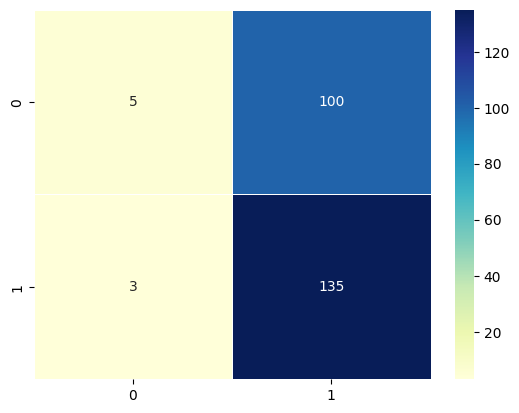

In [ ]:
clf_stack = XGBClassifier()
clf_stack.fit(X_train_stack, y_train)

y_pred_stack_train = clf_stack.predict(X_train_stack)
y_pred_stack = clf_stack.predict(X_test_stack)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_stack_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_stack), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_stack))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Fitting 5 folds for each of 3645 candidates, totalling 18225 fits
              precision    recall  f1-score   support

           0       0.45      0.05      0.09       105
           1       0.57      0.96      0.71       138

    accuracy                           0.56       243
   macro avg       0.51      0.50      0.40       243
weighted avg       0.52      0.56      0.44       243

ROC_score:  0.5020703933747412


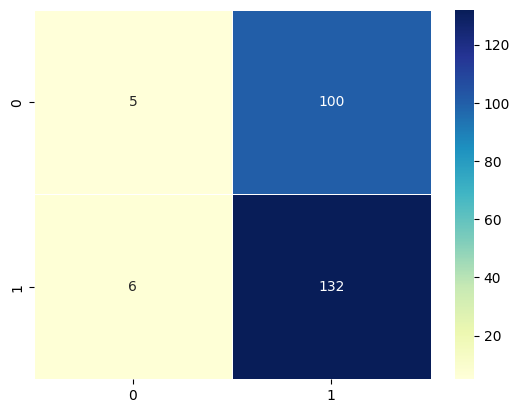

In [ ]:

# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
gs = GridSearchCV(XGBClassifier(), param_grid,  scoring='accuracy',
                  cv=5, verbose=3, n_jobs=-1)

# Fit randomized search object to data
gs.fit(X_train_stack, y_train)

gs_best = gs.best_estimator_
y_pred = gs_best.predict(X_test_stack)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


In [ ]:
with open('models/clf_stack.pkl', 'wb') as f:
    pickle.dump(gs_best, f)